In [1]:
import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

train_data = datasets.MNIST('../data', download=True, transform=transform, train=True)
test_data = datasets.MNIST('../data', download=True, transform=transform, train=False)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)


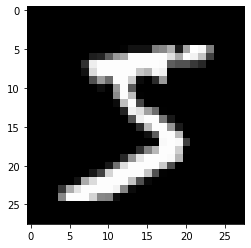

In [3]:
# visualize
fig = plt.figure(figsize=(25,4))
images, labels = iter(train_loader).next()
images = images.numpy()

img = np.squeeze(images[0])
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Linear AutoEncoder

In [4]:
import torch.nn as nn
import torch.nn.functional as F
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        self.fc1 = nn.Linear(28 * 28, encoding_dim)
        ## decoder ##
        self.fc2 = nn.Linear(encoding_dim, 28*28)
        
    def forward(self, x):
        # add layer, with relu activation function
        x = F.relu(self.fc1(x))
        # output layer (sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.fc2(x))
        return x

# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim)


## Training

In [5]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 2.962186
Epoch: 2 	Training Loss: 1.415330
Epoch: 3 	Training Loss: 1.095565
Epoch: 4 	Training Loss: 0.905442
Epoch: 5 	Training Loss: 0.821339
Epoch: 6 	Training Loss: 0.801124
Epoch: 7 	Training Loss: 0.792100
Epoch: 8 	Training Loss: 0.785764
Epoch: 9 	Training Loss: 0.779590
Epoch: 10 	Training Loss: 0.775659
Epoch: 11 	Training Loss: 0.773248
Epoch: 12 	Training Loss: 0.770906
Epoch: 13 	Training Loss: 0.767457
Epoch: 14 	Training Loss: 0.765814
Epoch: 15 	Training Loss: 0.764353
Epoch: 16 	Training Loss: 0.762509
Epoch: 17 	Training Loss: 0.761678
Epoch: 18 	Training Loss: 0.759875
Epoch: 19 	Training Loss: 0.759047
Epoch: 20 	Training Loss: 0.758018


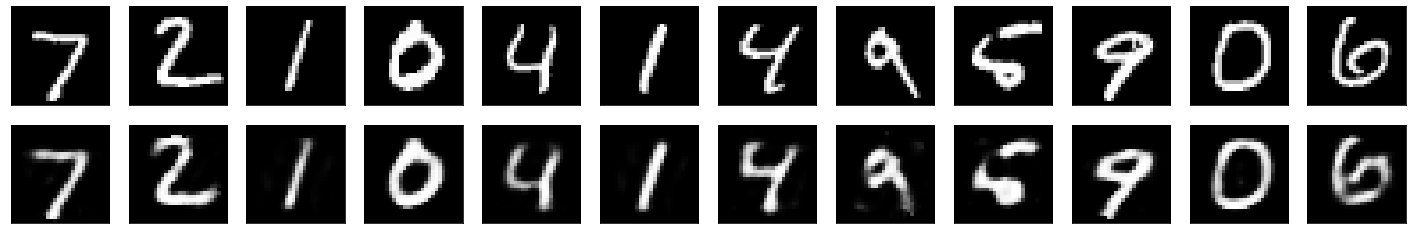

In [10]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(64, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=12, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Convolutional Autoencoder

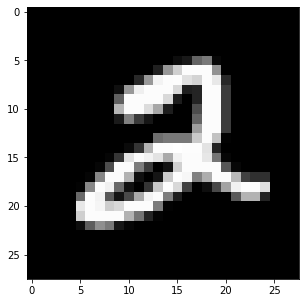

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[5])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [5]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = torch.sigmoid(self.t_conv2(x))
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
epochs = 3
train_loss = 0.0
for e in range(epochs):
    for images, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    train_loss = train_loss/len(train_loader)
    print(f'Epoch: {e+1}, Training Loss: {train_loss:.4f}')

Epoch: 1, Training Loss: 3.2191
Epoch: 2, Training Loss: 1.2051
Epoch: 3, Training Loss: 1.0314


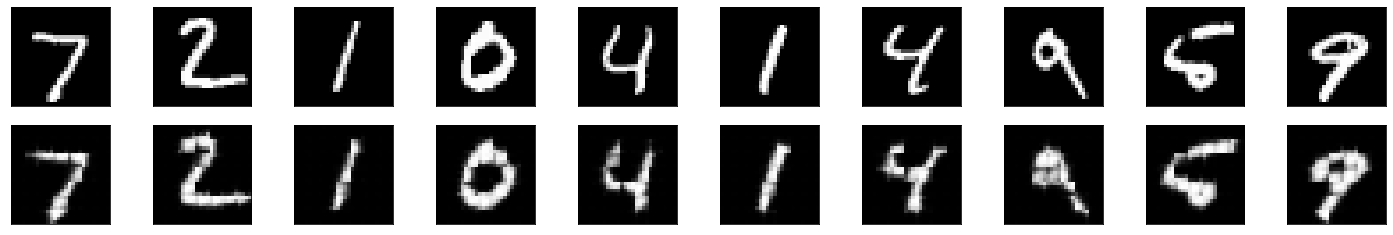

In [9]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(64, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Convolution autoencoder with upsampling

In [3]:
class ConvAutoencoderUpsample(nn.Module):
    def __init__(self):
        super(ConvAutoencoderUpsample, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2,2)
        #decode
        self.t_conv1 = nn.Conv2d(4,16, 3, padding=1)
        self.t_conv2 = nn.Conv2d(16, 1, 3, padding=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # decode and upsample/interpolate
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = F.relu(self.t_conv1(x))
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = torch.sigmoid(self.t_conv2(x))
        return x
model = ConvAutoencoderUpsample()
model

ConvAutoencoderUpsample(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (t_conv2): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [4]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
## training loop
for e in range(3):
    train_loss = 0.0
    for images, _ in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    train_loss = train_loss/len(train_loader) 
    print(f'Epoch: {e+1} Training Loss: {train_loss}')

Epoch: 1 Training Loss: 1.8755862338583607
Epoch: 2 Training Loss: 0.7958168879882105
Epoch: 3 Training Loss: 0.6869127367859456


In [27]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(64, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

torch.Size([32, 1, 28, 28])